In [6]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey
import pandas as pd
from scipy.interpolate import NearestNDInterpolator

In [7]:
from simpegskytem import Utils

In [8]:
mesh, models = Mesh.TensorMesh.read_vtk('./time-lapse-synthetic.vtr')

In [9]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt("./data/waveform_hm_304.txt")
waveform_lm_304 = np.loadtxt("./data/waveform_lm_304.txt")
time_input_currents_hm_304 = waveform_hm_304[:,0] 
input_currents_hm_304 = waveform_hm_304[:,1]
time_input_currents_lm_304 = waveform_lm_304[:,0] 
input_currents_lm_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt("./data/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

In [10]:
rho_1 = models['rho_1']
rho_3 = models['rho_3']
active_inds = mesh.gridCC[:,2] < 0.

In [11]:
tmp = rho_3.copy()
tmp[~active_inds.astype(bool)] = np.nan

In [12]:
from matplotlib.colors import LogNorm

(<matplotlib.collections.QuadMesh at 0x2afc2d0db9d0>,)

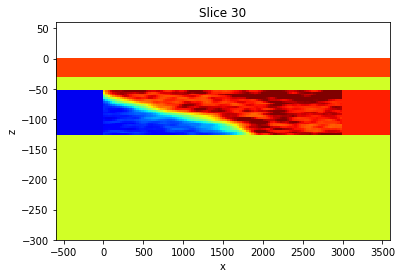

In [13]:
mesh.plotSlice(rho_3, clim=(0.3, 100), normal='y', pcolorOpts={'norm':LogNorm(), 'cmap':'jet'})

In [14]:
xmin, xmax = 0, 2800
# generate survey
x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
x = mesh.vectorCCx[x_inds][1::2]
y = np.zeros_like(x)
src_height = 40.
z = np.ones_like(x) * 0.
src_locations = np.c_[x, y, z + src_height]
rx_locations = np.c_[x+13.25, y, z+2.+ src_height]
n_sounding = src_locations.shape[0]
topo = np.c_[x, y, z*0.]

In [15]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_hm_304,
    time_input_currents_hm_304,
    input_currents_hm_304,
    25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_lm_304,
    time_input_currents_dual_moment=time_input_currents_lm_304,
    input_currents_dual_moment=input_currents_lm_304,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho_3, 
    actv=active_inds, 
    parallel_option='multiprocess'
)
simulation.pair(survey)

>> Set parameters


In [16]:
print (survey.n_sounding)

46


In [17]:
# write inputs to the disk
simulation.write_inputs_on_disk_pool()

In [18]:
%time data = simulation.forward(1./rho_3)

CPU times: user 55 ms, sys: 160 ms, total: 215 ms
Wall time: 12.8 s


In [19]:
np.save('./data/data_2', data)

In [20]:
DATA = data.reshape((times_hm_304.size+times_lm_304.size, n_sounding), order='F')
DATA_HM = -DATA[:times_hm_304.size,:]
DATA_LM = -DATA[times_hm_304.size:,:]

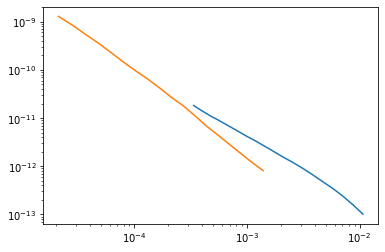

In [21]:
i_sounding = 0
plt.loglog(times_hm_304, DATA_HM[:,i_sounding])
plt.loglog(times_lm_304, DATA_LM[:,i_sounding])